In [113]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Reading the data and parsing dates, Making it index and sorted

In [114]:
path = r"path\to\the\file\stocks\A.csv"
df = pd.read_csv(path,parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

In [115]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


### Checking of any NULL

In [116]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### IQR method for identifying the outliers

#### close

In [117]:
q1=df["Close"].quantile(0.25)
q3=df["Close"].quantile(0.75)

IQR = q3-q1

lower_bound = q1-1.5*IQR
upper_bound = q3+1.5*IQR

In [118]:
outliers = df[(df["Close"]<lower_bound) | (df["Close"]>upper_bound)]

In [119]:
outliers.count()

Open         269
High         269
Low          269
Close        269
Adj Close    269
Volume       269
dtype: int64

### Replacing outliers with rolling mean

In [120]:
rolling_mean = df["Close"].rolling(window=5,center=True).mean()
df["Close_smoothed"]=df["Close"]
df.loc[(df["Close"]<lower_bound) | (df["Close"]>upper_bound), 'Close_smoothed'] = rolling_mean

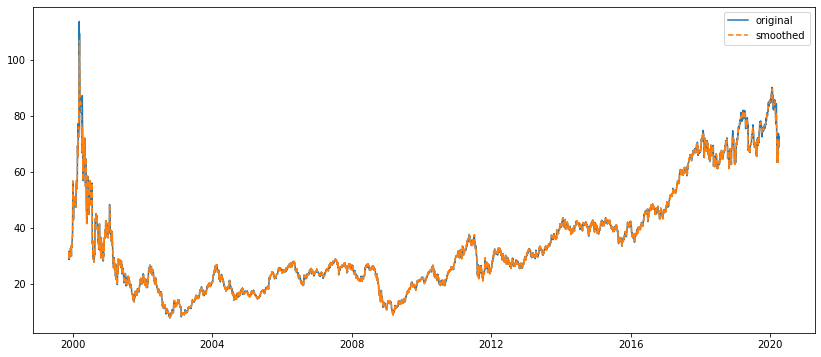

In [121]:
plt.figure(figsize=(14,6))
plt.plot(df["Close"],label="original")
plt.plot(df["Close_smoothed"],label="smoothed", linestyle="--")
plt.legend()
plt.show()

### Feature Engineering

In [122]:
df["Close t-1"] = df["Close_smoothed"].shift(1) # Yesterday's closing
df["Close t-2"] = df["Close_smoothed"].shift(2) # Day before Yesterday's closing
df["Volume t-1"] = df["Volume"].shift(1) # Yesterday's Volume

df["MA_5"] = df["Close_smoothed"].rolling(window=5).mean() # Moving  average of 5 days
df["EMA_10"] = df["Close_smoothed"].ewm(span=10, adjust=False).mean() # Exponential moving average of 10 days
df["Rolling_std_5"] = df["Close_smoothed"].rolling(window=5).std() # rolling standatd deviation of 5 days

In [123]:
df["Return_1d"] = df["Close_smoothed"].pct_change() # percentage change from yesterdays return
df["Return_5d"] = df["Close_smoothed"].pct_change(periods=5) # percentage change of 5 days return

### Candle Pattern

In [124]:
df["Bullish"] = (df["Close_smoothed"]>df["Open"]).astype(int)
df["Bearish"] = (df["Close_smoothed"]<df["Open"]).astype(int)
df["Gap_up"] = (df["Open"]>df["High"].shift(1)).astype(int)
df["Gap_down"] = (df["Open"]<df["Low"].shift(1)).astype(int)

In [125]:
df.drop("Close",axis=1,inplace=True)

In [126]:
df.head()

,Open,High,Low,Adj Close,Volume,Close_smoothed,Close t-1,Close t-2,Volume t-1,MA_5,EMA_10,Rolling_std_5,Return_1d,Return_5d,Bullish,Bearish,Gap_up,Gap_down
Date,,,,,,,,,,,,,,,,,,
1999-11-18,32.546494,35.765381,28.612303,27.068665,62546300,31.473534,NaN,NaN,NaN,NaN,31.473534,NaN,NaN,NaN,0,1,0,0
1999-11-19,30.713520,30.758226,28.478184,24.838577,15234100,28.880543,31.473534,NaN,62546300.0,NaN,31.002081,NaN,-0.082386,NaN,0,1,0,0
1999-11-22,29.551144,31.473534,28.657009,27.068665,6577800,31.473534,28.880543,31.473534,15234100.0,NaN,31.087799,NaN,0.089783,NaN,1,0,0,0
1999-11-23,30.400572,31.205294,28.612303,24.607880,5975600,28.612303,31.473534,28.880543,6577800.0,NaN,30.637709,NaN,-0.090909,NaN,0,1,0,0
1999-11-24,28.701717,29.998211,28.612303,25.261524,4843200,29.372318,28.612303,31.473534,5975600.0,29.962446,30.407638,1.406096,0.026563,NaN,1,0,0,0


### Date Features

In [127]:
df["day_of_week"] = df.index.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)
df["day_of_month"]=df.index.day
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["is_month_end"]=df.index.is_month_end.astype(int)
df["is_quarter_end"]=df.index.is_quarter_end.astype(int)
df["week_of_year"]=df.index.isocalendar().week
df["year"]=df.index.year

In [128]:
df["target"] = df["Close_smoothed"].shift(-1)

In [129]:
df.fillna(0, inplace=True)

In [131]:
x = df.drop("target",axis=1)
y=df["target"]

In [132]:
tscv = TimeSeriesSplit(n_splits=5)

Fold 1
rmse: 0.5654


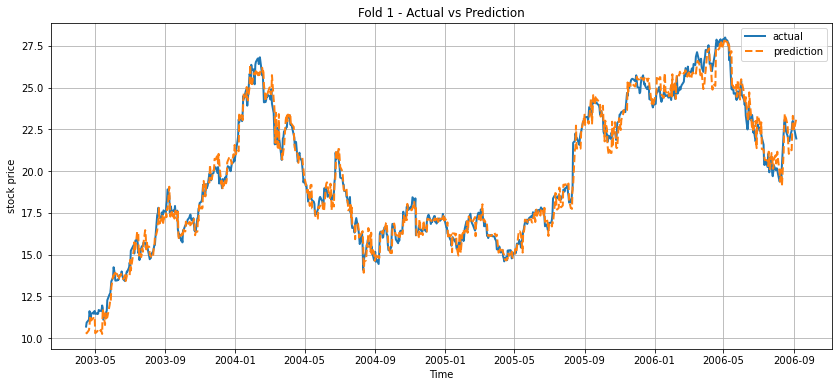

Fold 2
rmse: 0.7424


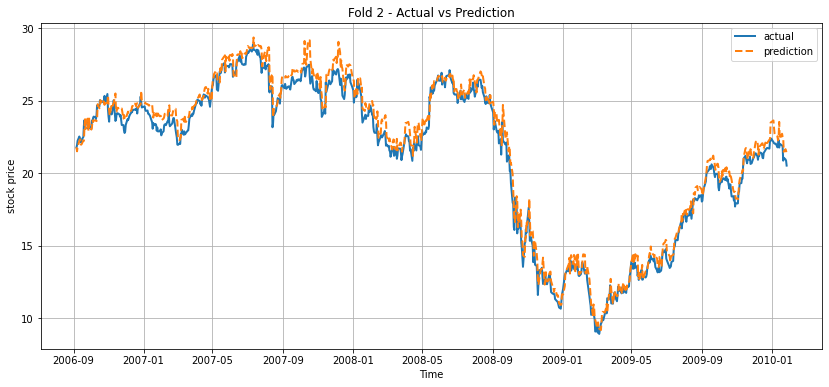

Fold 3
rmse: 1.0241


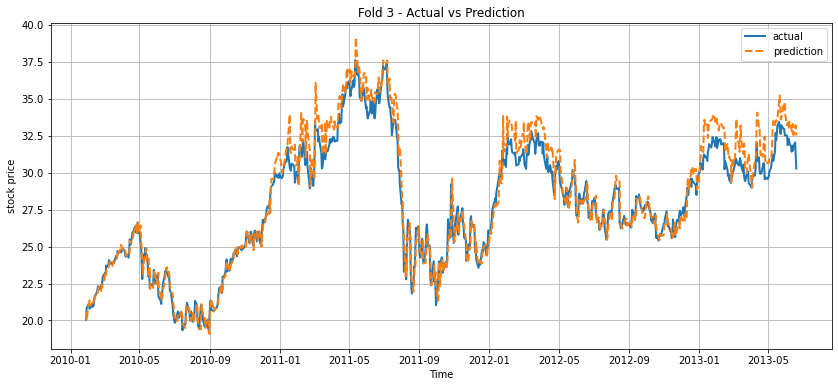

Fold 4
rmse: 1.8318


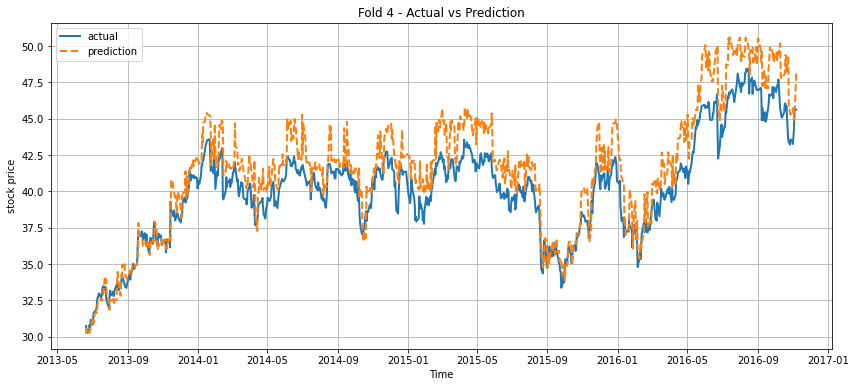

Fold 5
rmse: 3.1342


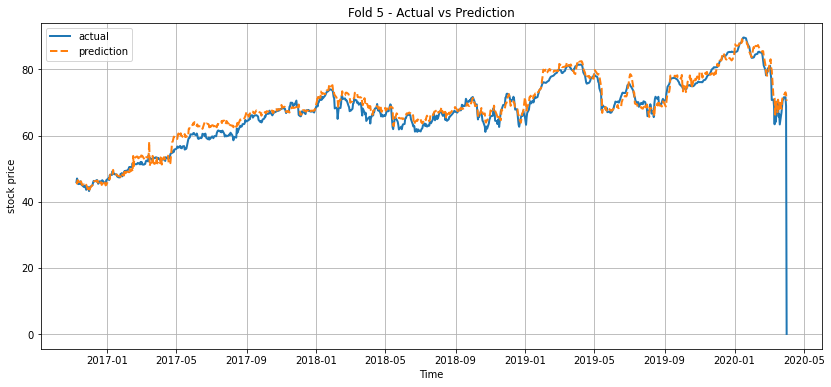

In [135]:
for fold, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {fold+1}")
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestRegressor()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"rmse: {rmse:.4f}")
    
    plt.figure(figsize=(14,6))
    plt.plot(y_test.index, y_test, label="actual", linewidth=2)
    plt.plot(y_test.index, y_pred, label="prediction", linewidth=2, linestyle='--')
    plt.title(f"Fold {fold+1} - Actual vs Prediction")
    plt.xlabel('Time')
    plt.ylabel('stock price')
    plt.legend()
    plt.grid(True)
    plt.show()